In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
import ast
from termcolor import colored
import string
from nltk.tokenize import word_tokenize 
from nltk.tokenize import TweetTokenizer 
from utils import spacy_tokenizer
import spacy
import string
from tqdm import trange, tqdm

sns.set_style('darkgrid')
tokenizer = TweetTokenizer()
nlp = spacy.load("en_core_web_md")

# Gráficas en LaTeX, a veces da problemas, en ese caso comentar y reiniciar kernel
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# For my jupyter theme
%config InlineBackend.print_figure_kwargs = {'facecolor':'white'}

In [27]:
# !pip install -U spacy
# !python -m spacy download en_core_web_md

- [Preprocesamiento](#Preprocesamiento)
- [LSTM](#LSTM)
  - [Embeddings](#Embeddings)
  - [Training](#Training)
- [Evaluación](#Evaluación)

<a name="Preprocesamiento"></a>
## Preprocesamiento

El mayor problema son las publicaciones que están como [ ], así que tratamos 3 preprocesamientos distintos (aplicando siempre `remove_symbols`):

1. Dejando [ ] como están:
  - **best-model-try1.pt**, *train*=0.6198, *test*=0.6258.
2. Poner los posts con [ ] como completamente tóxicos:
  - **best-model-try2.pt**, *train*=0.6498 , *test*=0.6526 
3. Dropping [ ] del dataset de training:
  - **best-model-try3.pt**, *train*=0.7260, *test*=0.6459
  
Mejor score en Codalab: 0.6488.

In [28]:
from utils import color_toxic_words, remove_symbols, completely_toxic, separate_words

In [29]:
train = pd.read_csv('../Datos/tsd_train.csv', converters={'spans':ast.literal_eval})
test = pd.read_csv('../Datos/tsd_trial.csv', converters={'spans':ast.literal_eval})
evaluation = pd.read_csv('../Datos/tsd_test.csv')

In [30]:
train['spans_clean'] = train['spans']
test['spans_clean'] = test['spans']

In [31]:
# Preprocesamiento-1: dejando [ ] como están

# # Quitamos símbolos
# indices_clean = [remove_symbols(index, text) for index,text in zip(train['spans'], train['text'])]
# train['spans_clean'] = indices_clean

# # Pasamos a minúscula
# train['text'] = train['text'].apply(lambda x:x.lower())

In [32]:
# Preprocesamiento-2: poner los posts con [ ] como completamente tóxicos

clean_spans = [completely_toxic(span, text) for (span, text) in zip(train['spans'], train['text'])]
train['spans_clean'] = clean_spans

# Quitamos símbolos
indices_clean = [remove_symbols(index, text) for index,text in zip(train['spans'], train['text'])]
train['spans_clean'] = indices_clean

# Pasamos a minúscula
train['text'] = train['text'].apply(lambda x:x.lower())

In [33]:
# Preprocesamiento-3: quitar las publicaciones [ ] del conjunto de entrenamiento

# indices = [i for i in train.index if len(train.loc[i]['spans']) == 0]
# train = train.drop(indices)

# # Quitamos símbolos
# indices_clean = [remove_symbols(index, text) for index,text in zip(train['spans'], train['text'])]
# train['spans_clean'] = indices_clean

# # Pasamos a minúscula
# train['text'] = train['text'].apply(lambda x:x.lower())

<a name="LSTM"></a>
## LSTM

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torch.cuda.current_device(), torch.cuda.get_device_name(0)

dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'

<a name="Embeddings"></a>
### Cargar embeddings

Checar [Deep Learning For NLP with PyTorch and Torchtext](https://towardsdatascience.com/deep-learning-for-nlp-with-pytorch-and-torchtext-4f92d69052f).

In [35]:
from torchtext.data import Field

In [36]:
# Descargar embeddings en caso de que no estén, puede tardar un rato

from torchtext.vocab import GloVe
GloVe(name='twitter.27B', dim=200)

In [37]:
# Aquí había un problema, estábamos usando 2 tokenizadores diferentes para sacar los
# embeddings y para preprocesar el texto para entrenar. Pondré el de SpaCy como 
# tokenizador en común con el corpus de 'en_core_web_md'

text_field = Field(
    tokenize='spacy',
    tokenizer_language='en_core_web_md',
    lower=True
)
label_field = Field(sequential=False, use_vocab=False)
# sadly have to apply preprocess manually
preprocessed_text = train['text'].apply(lambda x: text_field.preprocess(x))
# load fastext simple embedding with 300d
text_field.build_vocab(
    preprocessed_text, 
    vectors='glove.twitter.27B.200d'
)
# get the vocab instance
vocab = text_field.vocab

In [38]:
# El tokenizador hace bien su trabajo, los embeddings existen siempre y cuando la 
# palabra esté en el dataset de entrenamiento
vocab.lookup_indices(["f**k", 'dont', "do", "n't", '...', "are", 'a**hole', 'asshole'])

[4353, 12785, 29, 24, 57, 16, 7312, 980]

<a name="Training"></a>
### Training

Primero preparemos los datos para poder pasárselos a la LSTM.

In [39]:
from torch.utils.data import Dataset, DataLoader
from torch import autograd
import torch.optim as optim
from utils import get_index_toxic_words, f1, f1_scores, plot_loss_and_score

In [40]:
train_data = []
for index, text in tqdm(zip(train['spans_clean'], train['text']), total=len(train)):
    toxic_words = [text[i[0]:i[-1]+1] for i in separate_words(index) if len(index) > 0]
#     print(toxic_words)
    
    tokens = spacy_tokenizer(text)
    tagged_tokens = []
    
    for token in tokens:
        if token in toxic_words:
            tagged_tokens.append('toxic')
            # Removemos en caso de que se repita posteriormente pero esté como 'non_toxic'
            toxic_words.remove(token) 
        else:
            tagged_tokens.append('non_toxic')
            
    train_data.append((tokens, tagged_tokens, text, index))

100%|██████████| 7939/7939 [00:46<00:00, 169.17it/s]


In [41]:
test_data = []
for index, text in tqdm(zip(test['spans'], test['text']), total=len(test)):
    toxic_words = [text[i[0]:i[-1]+1] for i in separate_words(index) if len(index) > 0]
#     print(toxic_words)
    
    tokens = spacy_tokenizer(text)
    tagged_tokens = []
    
    for token in tokens:
        if token in toxic_words:
            tagged_tokens.append('toxic')
            # Removemos en caso de que se repita posteriormente pero esté como 'non_toxic'
            toxic_words.remove(token) 
        else:
            tagged_tokens.append('non_toxic')
            
    test_data.append((tokens, tagged_tokens, text, index))

100%|██████████| 690/690 [00:04<00:00, 169.73it/s]


In [42]:
def prepare_sequence(seq):
    idxs = vocab.lookup_indices(seq)      # Si no está lo pone como 0
    return torch.tensor(idxs, dtype=torch.long, device=dev)
def prepare_sequence_tags(seq):
    tag_to_ix = {"non_toxic": 0, "toxic": 1} 
    idxs = [tag_to_ix[s] for s in seq]
    return torch.tensor(idxs, dtype=torch.long, device=dev)

In [43]:
class SpansDataset(Dataset):
    """Spans dataset."""

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        text = prepare_sequence(self.data[idx][0])
        spans = prepare_sequence_tags(self.data[idx][1])
        sample = {'tokenized' : self.data[idx][0], 'original_text' : self.data[idx][2], 'text': text, 'spans': spans, 'true_index' : self.data[idx][3]}

        return sample

In [44]:
train_size = len(train_data)
test_size = len(test_data)

train_ds = SpansDataset(train_data)
test_ds = SpansDataset(test_data)

# Having bigger batches WILL make training faster
# However big batches are more difficult in RNNs in general due to variable sequence size, 
# they need padding.
trainloader = DataLoader(train_ds, batch_size=1, shuffle=True)

# Test is dev in reality
testloader = DataLoader(test_ds, batch_size=1, shuffle=True)

In [45]:
# word_to_ix = {'UNK': 0}

# for sent, tags in train_data:
#     for word in sent:
#         if word not in word_to_ix:              # word has not been assigned an index yet
#             word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
            
tag_to_ix = {"non_toxic": 0, "toxic": 1}        # Assign each tag with a unique index

In [46]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, stacked_layers, dropout_p, weight, hidden_dim, vocab_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim         # Dimension del estado oculta en cada direccion de la LSTM
        self.stacked_layers = stacked_layers # Cuantas capas en la LSTM
        
        self.word_embeddings = nn.Embedding.from_pretrained(weight)
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers = stacked_layers,
                            dropout = dropout_p,
                            bidirectional = True)

        # Linear layers
        self.fc1 = nn.Linear(hidden_dim*2, 1) # 2 veces el tamaño de hidden_dim por ser bidireccional

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        output, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        x = torch.sigmoid(self.fc1(output.view(len(sentence), -1)))
        return x

In [47]:
def tagger_LSTM(text, threshold=0.5):
    """
    Hace el tagging con el modelo que entrenamos.
    """
    ix_to_tag = {0: 'non_toxic', 1: 'toxic'}
    words = spacy_tokenizer(text.lower()) # Parece funcionar mejor
    
    with torch.no_grad():
        inputs = prepare_sequence(words)
        tag_scores = model(inputs)
        
        tags = [1 if x > threshold else 0 for x in tag_scores]

        tagged_sentence = list(zip(words, tags))

    return tagged_sentence

In [48]:
loss_per_epoch = [0]
training_loss = [0]
f1_scores_train = [0]
f1_scores_dev = [0]
stop_after_best = 100
best_l = None
best_tl = None
worst_l = None
worst_tl = None
worst_l_f1 = None
best_l_f1 = None
worst_tl_f1 = None
last_epoch_save = 0

Training on: GeForce RTX 2070
###############################################
Current epoch: 3
Last model save was in epoch 2
Stopping training in: 10 epochs.
###############################################
[Best iter] training F1 is: 0.4518983989760135
[Best iter] dev F1 is: 0.5245911035809205
###############################################
[Last iter] training F1 was: 0.4518983989760135
[Last iter] dev. F1 was: 0.5245911035809205
###############################################


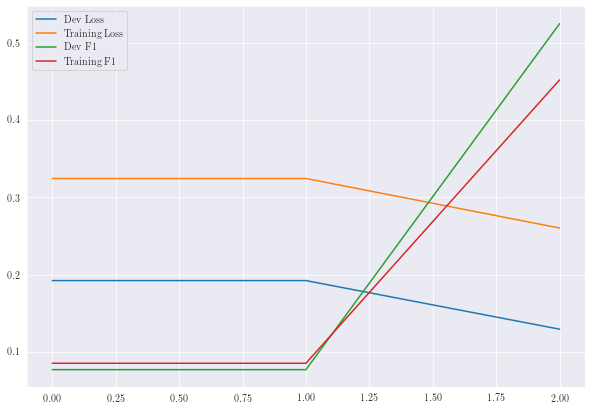

 66%|██████▌   | 5244/7939 [04:54<02:31, 17.81it/s]


KeyboardInterrupt: 

In [49]:
%matplotlib inline

# Deben ir en la misma celda donde se entrena, de lo contrario no fija la semilla
torch.manual_seed(42)

# try2
HIDDEN_DIM = 600
embedding_dim = len(vocab.vectors[0])
model = LSTMTagger(embedding_dim, 6, 0.2, vocab.vectors, HIDDEN_DIM, len(vocab.vectors))
model.to(torch.device(dev)) # Lo mueve a la GPU, en caso de que haya
# model.cuda()              # Pasa todo a la GPU, da error si no hay GPU

criterion = nn.BCELoss()
#optimizer = optim.SGD(model.parameters(), momentum = 0.85, lr=0.0005)
optimizer = optim.Adam(model.parameters())

# Antes eran 100
stop_after_best = 10
# Nombre del archivo de backup
savefile = 'Modelos/best-model-try2pt'

epochs_without_change = 0
epochs = len(loss_per_epoch)

# Se itera hasta que no mejore el desempeño en dev por 'stop_after_best' épocas
while epochs_without_change < stop_after_best:  
    display.clear_output(wait=True)
    print("Training on: " + torch.cuda.get_device_name(torch.cuda.current_device()))
    print("###############################################")
    print("Current epoch: " + str(epochs))
    print("Last model save was in epoch " + str(last_epoch_save))
    print("Stopping training in: " + str(stop_after_best - epochs_without_change) + " epochs.")
    print("###############################################")
    print("[Best iter] training F1 is: " + str(best_tl))
    print("[Best iter] dev F1 is: " + str(best_l))
    print("###############################################")
    print("[Last iter] training F1 was: " + str(f1_scores_train[-1]))
    print("[Last iter] dev. F1 was: " + str(f1_scores_dev[-1]))
    print("###############################################")
    #Dibujo lo que puedo
    plt.figure(figsize=(10,7))
    plt.plot(range(epochs), loss_per_epoch)
    plt.plot(range(epochs), training_loss)
    plt.plot(range(epochs), f1_scores_dev)
    plt.plot(range(epochs), f1_scores_train)
    plt.legend(["Dev Loss", "Training Loss", "Dev F1", "Training F1"])
    plt.show()
    tl = 0
    t_pred_l = []
    t_true_index_l = []
    t_tokenized_l = []
    t_text_l = []
    for i,v in tqdm(enumerate(trainloader), total=len(trainloader)): #Not using batches yet
        text = torch.reshape(v['text'], (-1,))
        tags = torch.reshape(v['spans'], (-1,))
        optimizer.zero_grad()
        tag_scores = model(text)
        
        #Para la F1
        t_pred_l.append(tag_scores.cpu().detach().numpy())
        t_true_index_l.append([a.cpu().detach().numpy()[0] for a in v['true_index']])
        t_tokenized_l.append([a[0] for a in v['tokenized']])
        t_text_l.append(v['original_text'][0])
        
        loss = criterion(torch.reshape(tag_scores, (-1,)), torch.reshape(tags, (-1,)).float())
        tl += loss.item()
        loss.backward()
        optimizer.step()

    tl /= len(trainloader)
    l = 0
    print("Starting evaluation for loss function.")
    # evaluar el modelo
    pred_l = []
    true_index_l = []
    tokenized_l = []
    text_l = []
    
    model.eval()
    with torch.no_grad():
        for v in testloader:
            text = torch.reshape(v['text'], (-1,))
            tags = torch.reshape(v['spans'], (-1,))

            tag_scores = model(text)
            
            #Para la F1
            pred_l.append(tag_scores.cpu().detach().numpy())
            true_index_l.append([a.cpu().detach().numpy()[0] for a in v['true_index']])
            tokenized_l.append([a[0] for a in v['tokenized']])
            text_l.append(v['original_text'][0])
            
            loss = criterion(torch.reshape(tag_scores, (-1,)), torch.reshape(tags, (-1,)).float())
            l += loss.item()
    model.train()
    l /= len(testloader)
    print("Starting evaluation for dev F1")
    f1_d = f1_scores(pred_l, true_index_l, tokenized_l, text_l)
    # Es aproximado, pero solo es una referencia
    f1_t = f1_scores(t_pred_l, t_true_index_l, t_tokenized_l, t_text_l) 
    
    
    epochs_without_change += 1
    if best_l is None or best_l < f1_d:
        print("Model improved, saving.")
        torch.save(model, savefile)
        best_l = f1_d
        best_tl = f1_t
        epochs_without_change = 0
        last_epoch_save = epochs
        print("Model improved, saved.")
    # Para graficar con una escala coherente.
    if(worst_l_f1 is None or f1_d < worst_l_f1):
        worst_l_f1 = f1_d
        f1_scores_dev[0] = worst_l_f1
    if(worst_tl_f1 is None or f1_t < worst_tl_f1):
        worst_tl_f1 = f1_t
        f1_scores_train[0] = worst_tl_f1
    if(worst_tl is None or tl > worst_tl):
        worst_tl = tl
        training_loss[0] = worst_tl
    if(worst_l is None or l > worst_l):
        worst_l = l
        loss_per_epoch[0] = worst_l
    # Rastreo las perdidas
    loss_per_epoch.append(l)
    training_loss.append(tl)
    f1_scores_train.append(f1_t)
    f1_scores_dev.append(f1_d)
    # Rastreo la época actual
    epochs += 1
print('Finished Training')

In [ ]:
plot_loss_and_score(training_loss, loss_per_epoch, f1_scores_train, f1_scores_dev, show=False)
plt.savefig('../Images/preprocesamiento-2.pdf', bbox_inches='tight')
plt.show()

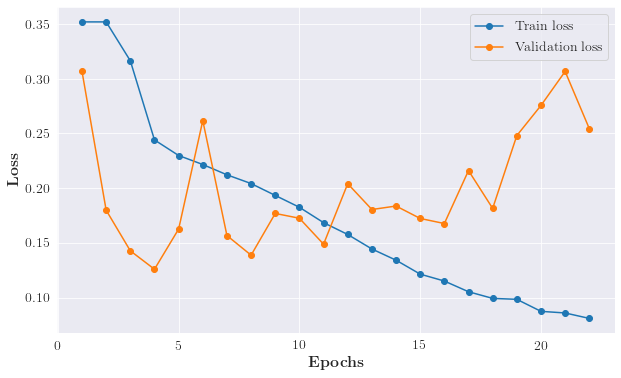

In [28]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(1, len(training_loss) + 1), training_loss, marker='o', label='Train loss')
plt.plot(np.arange(1, len(loss_per_epoch) + 1), loss_per_epoch, marker='o', label='Test loss')
plt.xlabel(r'\textbf{Epochs}',size=16)
plt.ylabel(r'\textbf{Loss}', size=16)
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.savefig('../Images/preprocesamiento-2-1.pdf', bbox_inches='tight')
plt.show()

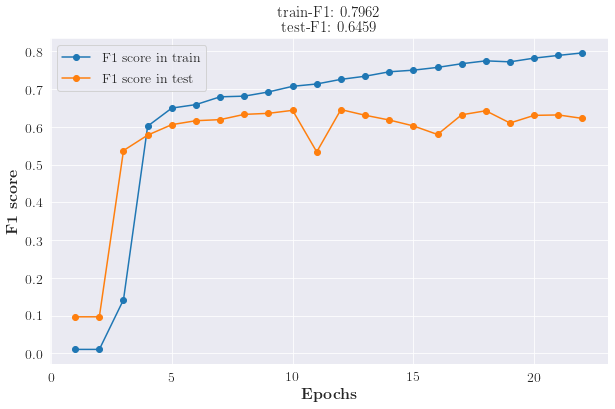

In [29]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(1, len(f1_scores_train) + 1), f1_scores_train, marker='o', label='F1 score in train')
plt.plot(np.arange(1, len(f1_scores_dev) + 1), f1_scores_dev, marker='o', label='F1 score in test')
plt.xlabel(r'\textbf{Epochs}',size=16)
plt.ylabel(r'\textbf{F1 score}', size=16)
plt.tick_params(labelsize=14)
title = 'train-F1: {:.4f} \n  test-F1: {:.4f}'.format(np.max(f1_scores_train), np.max(f1_scores_dev))
plt.title(title, size=15)
plt.legend(fontsize=14)
plt.savefig('../Images/preprocesamiento-7-2.pdf', bbox_inches='tight')
plt.show()

Para graficar la red ver [Visualize a net in PyTorch?](https://stackoverflow.com/questions/52468956/how-do-i-visualize-a-net-in-pytorch)

<a name="Evaluación"></a>
## Evaluación

In [26]:
# model = torch.load('best-model-try2.pt')
# model.eval()

LSTMTagger(
  (word_embeddings): Embedding(19611, 200)
  (lstm): LSTM(200, 600, num_layers=6, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=1200, out_features=1, bias=True)
)

In [27]:
train = pd.read_csv('../Datos/tsd_train.csv', converters={'spans':ast.literal_eval})
test = pd.read_csv('../Datos/tsd_trial.csv', converters={'spans':ast.literal_eval})
evaluation = pd.read_csv('Datos/tsd_test.csv')

train['spans_clean'] = train['spans']
test['spans_clean'] = test['spans']

In [28]:
indices_test = []
for i,(gold_index,text) in enumerate(zip(test['spans_clean'],test['text'])):
    tagged_sentence = tagger_LSTM(text)   
    prediction_index = get_index_toxic_words(text.lower(), tagged_sentence)
    indices_test.append(prediction_index)
    print(str(i) + colored(' Pred: ', color='cyan', attrs=['bold']) + 
           color_toxic_words(prediction_index, text))
    print(str(i) + colored(' Gold: ', color='yellow', attrs=['bold']) + 
          color_toxic_words(gold_index, text) + '\n'*2)

0 Pred: Because he's a moron and a bigot. It's not any more complicated than that.
0 Gold: Because he's a moron and a bigot. It's not any more complicated than that.


1 Pred: How about we stop protecting idiots and let nature add some bleach to the gene pool. We can always submit their names for the Darwin awards.
1 Gold: How about we stop protecting idiots and let nature add some bleach to the gene pool. We can always submit their names for the Darwin awards.


2 Pred: If people  were  smart, they would  Boycott this  inept  airline,  but   they  are  not  smart,  so   rogue  businesses  like  this  one,   still thrive   taking the idiots  for  a ride...
2 Gold: If people  were  smart, they would  Boycott this  inept  airline,  but   they  are  not  smart,  so   rogue  businesses  like  this  one,   still thrive   taking the idiots  for  a ride...


3 Pred: Trump Claimed that Russia will never invade the Ukraine, when Russia already has - how stupid can people be?
3 Gold: Trump Claim

12 Pred: He's a psychopath.
12 Gold: He's a psychopath.


13 Pred: Clinton should be the last person to say anything about anyone. She is such a lying scum bag. I can't handle just hearing her voice. It would be a lot worse if she was President than we are with the crazy Trump. She would have her husband (AKA: as the cigar rapist) as her guide. He should have been arrested for doing that to that young girl, the starred eye Monica. How can anyone blame her but I certainly wouldn't have let him stick a cigar in me. It is the Media's fault because they keep going to get her big lying mouth going.
13 Gold: Clinton should be the last person to say anything about anyone. She is such a lying scum bag. I can't handle just hearing her voice. It would be a lot worse if she was President than we are with the crazy Trump. She would have her husband (AKA: as the cigar rapist) as her guide. He should have been arrested for doing that to that young girl, the starred eye Monica. How can anyone blame h

24 Pred: This guy must be from Nanakuli.  Are all the people there so ignorant and gross?  Yuk!
24 Gold: This guy must be from Nanakuli.  Are all the people there so ignorant and gross?  Yuk!


25 Pred: 465 million is chump change to Mylan.  Their profits are so ridiculous that it won't even make a dent for them to pay this penalty.  They are still more than eager to deprive hard working people of life saving drugs in order to keep those billions coming in.  How long are Americans going to put up with this blatant and unashamed profiteering?  Maybe when enough folks die because they get stung by a bee or eat shellfish and can't afford to carry their EpiPen for emergency life saving epinephrine.
25 Gold: 465 million is chump change to Mylan.  Their profits are so ridiculous that it won't even make a dent for them to pay this penalty.  They are still more than eager to deprive hard working people of life saving drugs in order to keep those billions coming in.  How long are Americans goin

37 Pred: Are u stupid... did you not read article small amount of Marijuana...... massive amounts of meth and herion .... yep blame it on weed.... you obviously  never smoked any. If so you would realize a "reffer" head would have been to lazy and hungry to steal a boat.. as a matter of fact. I guarantee  alcohol  which is legal same as Marijuana  played huge part in this... not defending the meth heads or tweakers out there,  but really your simple minded antics are what is wrong with our community...
37 Gold: Are u stupid... did you not read article small amount of Marijuana...... massive amounts of meth and herion .... yep blame it on weed.... you obviously  never smoked any. If so you would realize a "reffer" head would have been to lazy and hungry to steal a boat.. as a matter of fact. I guarantee  alcohol  which is legal same as Marijuana  played huge part in this... not defending the meth heads or tweakers out there,  but really your simple minded antics are what is wrong with o

48 Pred: Hay good going jack ass. It's Jonny come latelys like your self that can't appreciate a place for what it is. 
So you have to share it with everyone else instead of keeping the majesty of the place for those who would find it on there own. And actually deserve it. 
Good job ****hole. 
Hope I don't see you up there.
48 Gold: Hay good going jack ass. It's Jonny come latelys like your self that can't appreciate a place for what it is. 
So you have to share it with everyone else instead of keeping the majesty of the place for those who would find it on there own. And actually deserve it. 
Good job ****hole. 
Hope I don't see you up there.


49 Pred: Life was so much easier (and fun) just a few months ago for the GOP and Trump chumps could just sit back and blame everything on President Obama and chant "Lock her up!" at their brown shirt rallies. 
Now that they control the Oval Office and both houses of Congress, they have no alternative to turn on each other for the historic failu

61 Pred: Having been on Hagemeister and seeing first hand the devastation, the only word in your diatribe that is accurate is 'stupid'. Another example of this man made ecological disaster is at the south end of Umnak Island where feral cattle and sheep have disturbed an archaeological site that is considered the oldest in the Aleutians. I've been there and helped rebury remains that were exposed from the animal caused erosion. To see literally hundreds of remains, exposed hearths and middens was deeply disturbing.

These animals have no value other than to a bored crabber and should be removed. They are no better than rats.
61 Gold: Having been on Hagemeister and seeing first hand the devastation, the only word in your diatribe that is accurate is 'stupid'. Another example of this man made ecological disaster is at the south end of Umnak Island where feral cattle and sheep have disturbed an archaeological site that is considered the oldest in the Aleutians. I've been there and helped 

78 Pred: Stop with the silly suggestions.  We all know what it is.

Clowns... Killer clowns...
78 Gold: Stop with the silly suggestions.  We all know what it is.

Clowns... Killer clowns...


79 Pred: stupid is as stupid does.....and trump is.........
79 Gold: stupid is as stupid does.....and trump is.........


80 Pred: Hey Dickie, as long as it crushes that smug holier-than-thou attitude held by 90% of Canadians, I'm ok with it.
Shadenfreude's a bitch.
80 Gold: Hey Dickie, as long as it crushes that smug holier-than-thou attitude held by 90% of Canadians, I'm ok with it.
Shadenfreude's a bitch.


81 Pred: F@#k all you libtards. Go move to California so when NKorea nukes it, a  good chunk of you dumba$$es will be gone for good.
81 Gold: F@#k all you libtards. Go move to California so when NKorea nukes it, a  good chunk of you dumba$$es will be gone for good.


82 Pred: Morons are people who take a misstatement and spin it to mean something stupid like saying Trump does not know he is 

90 Pred: What scam are they running now? Watch idiots jump on wagon and toot Walkers horn. I guess PFD is the guarantee for this lie.
90 Gold: What scam are they running now? Watch idiots jump on wagon and toot Walkers horn. I guess PFD is the guarantee for this lie.


91 Pred: You must not have read the part where I said "on a lighter note " .To a person who just turned on a TV it would look like something out of a crazy comedy movie .  No real hockey fan would want to attend a UAA hockey game and watch that goofball stuff.   You don't see Aces crowds , NHL crowds , or even other college hockey teams fans acting like they all just escaped a trailer park. There's a reason so few attend UAA hockey games----and showing those fans acting loonie tunes is one of the reasons. I was offering advice to help with UAA's pathetic attendance problems---saying don't show stuff like that on TV if you want real hockey fans to attend. I couldn't care in the least if you consider my comments credible o

96 Pred: I love how fellow troglodytes vote in agreement with you despite your falsehoods.   Let me see our middle class taxes were lowered and this also benefits the wealthy (but yes they did rise for those making over $200k - boo hoo).  Our corporate taxes are already in the 10-15% range and have been for a long time.   So where are these tax increased under Wynne or Trudeau, name them???   

You believe Trump can get rid of half (just a guess) of federal revenue and it will benefit society?  You think that is how it works?  Do tell.   How does the fact that within the next 20 years we will ALL lose another 10-20% of jobs due to technology?  Tell me how that factors in for you?  What about the fact that globally we are adding about 80 million more people a year but require less labour?  How does that factor in, let me tell you?  Should we always just let the .01% reap the benefits of technology none of them have invented?   Simple minded answers are for the far right among us.
96 Gol

112 Pred: It was ignorant.  You don't know me.  You don't know what I do or how often I buy cars.  I could be a fleet buyer.  You don't know--that's ignorance.

And it was snark.  You made a snide remark that was derogatory or mocking about how often I purchase cars.  A snide remark is snark.

Anything else you'd like to be taught today?
112 Gold: It was ignorant.  You don't know me.  You don't know what I do or how often I buy cars.  I could be a fleet buyer.  You don't know--that's ignorance.

And it was snark.  You made a snide remark that was derogatory or mocking about how often I purchase cars.  A snide remark is snark.

Anything else you'd like to be taught today?


113 Pred: Thieves!
113 Gold: Thieves!


114 Pred: Trump is too stupid to understand that in provoking China, he is not dealing with a defenseless country like Iraq or Libya. Besides its significant economic power, China is also a nuclear power, and can put together an army ten times the size that Americans can if nec

126 Pred: If you were being pimped out by your husband and beaten while he was sitting on his ass probably playing video games than who and what.. would you feel sorry for. It's time to not give these losers a break ok!!
126 Gold: If you were being pimped out by your husband and beaten while he was sitting on his ass probably playing video games than who and what.. would you feel sorry for. It's time to not give these losers a break ok!!


127 Pred: Go away.  Bigoted jerk!
127 Gold: Go away.  Bigoted jerk!


128 Pred: What a loser.

Someone has to start teaching these stupid kids that ascension to the lofty ranks of College Football Player does not absolve them of the responsibility to act like human beings.
128 Gold: What a loser.

Someone has to start teaching these stupid kids that ascension to the lofty ranks of College Football Player does not absolve them of the responsibility to act like human beings.


129 Pred: Your defence of the indefencible is sad, pathetic and weak.
129 Go

141 Pred: There is no bill. The 2% figure is a guideline. Numerous other countries are below Canada in their contributions and Canada spends a great deal of money on defense related activities that don't qualify for NATO, but do contribute to NATO. Coast Guard, for example. 

In other words, you're whining is misplaced. You've admitted you are an American and no doubt a Trump supporter. Good luck with acquiring support in Canada for that hapless buffoon.
141 Gold: There is no bill. The 2% figure is a guideline. Numerous other countries are below Canada in their contributions and Canada spends a great deal of money on defense related activities that don't qualify for NATO, but do contribute to NATO. Coast Guard, for example. 

In other words, you're whining is misplaced. You've admitted you are an American and no doubt a Trump supporter. Good luck with acquiring support in Canada for that hapless buffoon.


142 Pred: So what if Donald is a liar; he has other good qualities, like being a

153 Pred: You have to wonder how stupid you have to be to put your opinion on social media and not expect to to catch some heat when you bad mouth people.  Its is even stupider when you are in business dealing with the people you are bad mouthing.  Some folks thing it is ok to bad mouth people and not expect some heat claiming that it all someone else fault ie PC police.  The reality of is that his words will not change what gets shipped to the Bush communities but his words have cost him financially and may cost him even more in the future.  What few negative comments can do for something that is really not the pilots concern, if you don't want to deal with locals go back to Texas.
153 Gold: You have to wonder how stupid you have to be to put your opinion on social media and not expect to to catch some heat when you bad mouth people.  Its is even stupider when you are in business dealing with the people you are bad mouthing.  Some folks thing it is ok to bad mouth people and not expec

168 Pred: Great commentary. How did the Party of Lincoln deteriorate into the fraudster Party of Trump? How can a man who pretty much shamelessly lies every time he opens his mouth claim Hillary is untruthful (yes she occasionally lies too). How can a man born rich who markets himself as a rich elitist and a reputation sticking it to contractors and investors, claim to represent the middle class? How can a schoolyard bully claim to be a great negotiator?  Trump supporters, have you gone completely nuts?
168 Gold: Great commentary. How did the Party of Lincoln deteriorate into the fraudster Party of Trump? How can a man who pretty much shamelessly lies every time he opens his mouth claim Hillary is untruthful (yes she occasionally lies too). How can a man born rich who markets himself as a rich elitist and a reputation sticking it to contractors and investors, claim to represent the middle class? How can a schoolyard bully claim to be a great negotiator?  Trump supporters, have you gone

183 Pred: Are these some of those Russian pieces of crap that they seem to be building all over Alaska. People don't buy that poorly built Russian houses. You will regret it down the road. Good luck getting them to fix there slapped together houses to.
183 Gold: Are these some of those Russian pieces of crap that they seem to be building all over Alaska. People don't buy that poorly built Russian houses. You will regret it down the road. Good luck getting them to fix there slapped together houses to.


184 Pred: Nurnie/Saullie: and you're back with your foolishness and another silly handle.
184 Gold: Nurnie/Saullie: and you're back with your foolishness and another silly handle.


185 Pred: Like I said you can't grasp it. We have to put up with intolerant people here because  they were born here. Is it that hard of a concept. We do not let in those who are intolerant and give them Canadian rights. Your kids will have zero tolerance until your kids grow up and start living in the real w

194 Pred: It's still B.S. that non - natives have to import Reindeer if they want to raise them. That law is a big crock of sh*t. I would like to raise my own food.
194 Gold: It's still B.S. that non - natives have to import Reindeer if they want to raise them. That law is a big crock of sh*t. I would like to raise my own food.


195 Pred: This was an active shooter who already killed. I'm not sure this is someone we would ever want back out on the street. Only time will tell. Can't save them all. Personally, I think anyone who shoots 6 year olds should die. I'm not interested in giving killers on a shooting spree second chances. Killing his parent, ok, lots of reasons, he could have been abused, or acting in self-defense. We don't know at this point. But a shooting rampage at an elementary school? Never any kind of reason, it was cold blooded attempted murder. To make it worse, now these victims will have to go through a trial and relive this experience over and over for the next few 

206 Pred: True, but Gays and Lesbians should show a little restraint in their behavior.  Kissing and making out in front of children is taking it too far.  I read that this is what happened in front of the shooter's little 3 year old boy and that is what set him off.  That kind of behavior by Gays is extremism.
206 Gold: True, but Gays and Lesbians should show a little restraint in their behavior.  Kissing and making out in front of children is taking it too far.  I read that this is what happened in front of the shooter's little 3 year old boy and that is what set him off.  That kind of behavior by Gays is extremism.


207 Pred: The billion+ citizens of emerging ecomomies like China and India have a thirst for our conveneiences but can't afford electric cars.

They will easily fill the void of anyone who's foolish enough to buy an electric car once we run out of money subsidizing the 1%er's who already could afford these hyper-expensive vehicles even without these idiotic subsidies.
2

217 Pred: 151 years ago economist, philosopher and Liberal Member of Parliament John Stuart Mill famously referred to the (British) Conservative Party as "the stupidest party".

And for almost that long conservative parties around the world have strived to prove him right.
217 Gold: 151 years ago economist, philosopher and Liberal Member of Parliament John Stuart Mill famously referred to the (British) Conservative Party as "the stupidest party".

And for almost that long conservative parties around the world have strived to prove him right.


218 Pred: Avoiding "iffy" weather is not a solution.  Weather changes fast.  Pilots must be equipped and possess the skills to deal with it.  Regulators would do well to acknowledge this and stop with all the cowboy vs choir-boy talk.  And giving Medallion more money is not going to help either, because Medallion sucks.
218 Gold: Avoiding "iffy" weather is not a solution.  Weather changes fast.  Pilots must be equipped and possess the skills to d

229 Pred: You are the 'perfect' Democratic IDIOT.
229 Gold: You are the 'perfect' Democratic IDIOT.


230 Pred: My all time favorites are still Wyoming College (spend $20K per year on something slightly more legit than an online diploma mill and live in a trailer in rural Wyoming) and the now defunct Ave Maria College (come and hear Fr. Gruner's conspiracy theories and other schimatic garbage.)
230 Gold: My all time favorites are still Wyoming College (spend $20K per year on something slightly more legit than an online diploma mill and live in a trailer in rural Wyoming) and the now defunct Ave Maria College (come and hear Fr. Gruner's conspiracy theories and other schimatic garbage.)


231 Pred: Everytime I hear or see this I say THANK GOD I'M WHITE! I am terrified for my for my black relatives. I cannot imagine trying to raise black children in today's world. They are being killed over the stupidist reasons LEO can come up with! It breaks my brother's heart when his fellow LEO kill u

240 Pred: "It seems almost everyone is falling for it."

It's the same crap, different packaging. It drives me crazy that people fall for that just because of Politics.

Russians also made the ref overturn the Sanders catch then they hashtagged it to anger Bronco fans even more. 

You can use Russia for any excuse these days. All the ills of America can be blamed on yet another entity. Weird. Could swear I've seen this movie already.
240 Gold: "It seems almost everyone is falling for it."

It's the same crap, different packaging. It drives me crazy that people fall for that just because of Politics.

Russians also made the ref overturn the Sanders catch then they hashtagged it to anger Bronco fans even more. 

You can use Russia for any excuse these days. All the ills of America can be blamed on yet another entity. Weird. Could swear I've seen this movie already.


241 Pred: Judith M - that is a complete load of BS, and you and your fake news trolling idiots know it.
241 Gold: Judith M

263 Pred: Every country that has 50% or over Muslims makes for other faiths or individuals very hard to live. Talking about being victim, how about thousands of Indian who were tortured and killed because they would not accept Islam. What about their identity. What about identity of countless Christians in Arabic countries : like Iraq, Syria, etc tortured and killed I totally horrific ways but Muslims what about their victimization, what about their rights. 
Those articles written about current situations in this newspaper are totally pathetic. It’s a joke.
263 Gold: Every country that has 50% or over Muslims makes for other faiths or individuals very hard to live. Talking about being victim, how about thousands of Indian who were tortured and killed because they would not accept Islam. What about their identity. What about identity of countless Christians in Arabic countries : like Iraq, Syria, etc tortured and killed I totally horrific ways but Muslims what about their victimization,

277 Pred: Building rail to reduce traffic by2% = dumb.   Trusting HART and the city to build rail to Ala Moana, even with a 10 year GET extension = dumber.
277 Gold: Building rail to reduce traffic by2% = dumb.   Trusting HART and the city to build rail to Ala Moana, even with a 10 year GET extension = dumber.


278 Pred: Stupid conspiracy tin-foil hat wearers everywhere unite. As if there aren't enough real, actual  problems to deal with. Evidently false and blatently stupid fake news conspiraccy tales are just further proof that Americans as a populace are way too stupid to be allowed out without adult supervision.
278 Gold: Stupid conspiracy tin-foil hat wearers everywhere unite. As if there aren't enough real, actual  problems to deal with. Evidently false and blatently stupid fake news conspiraccy tales are just further proof that Americans as a populace are way too stupid to be allowed out without adult supervision.


279 Pred: Also Ervin is pointed out as black n the story. Why 

290 Pred: Stella St Page, That's one of the cheapest dumb blogs ever. Anybody that donates their time to bettering something, anything is doing something more than the complainers. You should be ashamed.
290 Gold: Stella St Page, That's one of the cheapest dumb blogs ever. Anybody that donates their time to bettering something, anything is doing something more than the complainers. You should be ashamed.


291 Pred: You are spouting nonsense.
291 Gold: You are spouting nonsense.


292 Pred: Yep Randy, statistics and facts, but those don't get in your way, do they?  Ignorant and foolish indeed.
292 Gold: Yep Randy, statistics and facts, but those don't get in your way, do they?  Ignorant and foolish indeed.


293 Pred: Such venom and hatred.  You probably have a picture of Kathy Griffin in your room.  No cure for stuck on stupid.
293 Gold: Such venom and hatred.  You probably have a picture of Kathy Griffin in your room.  No cure for stuck on stupid.


294 Pred: He is a joke.  He was ha

305 Pred: there it is in a 'nutshell'.  
fear, loathing, and hatred of  'liberals' is what drives these people.  
they would vote for a slate of kangaroos provided that the kangaroos were portrayed as the opposition to the 'liberal agenda'.

pathetic and mindless.
305 Gold: there it is in a 'nutshell'.  
fear, loathing, and hatred of  'liberals' is what drives these people.  
they would vote for a slate of kangaroos provided that the kangaroos were portrayed as the opposition to the 'liberal agenda'.

pathetic and mindless.


306 Pred: If you're stupid enough to have a back yard in bear territory, yes.
306 Gold: If you're stupid enough to have a back yard in bear territory, yes.


307 Pred: Oh trust me, the first pockets he will be picking are yours lol! Your a fool if you don't get that. I'm pro not letting any of those bastards in this country but your barking up the wrong tree. Vote libertarian
307 Gold: Oh trust me, the first pockets he will be picking are yours lol! Your a fool if

314 Pred: What these two judges did is mindboggling.  They said that foreigners living in foreign countries have a Constitutional right to come to the U.S.  Yes, that is the effect of their ruling.  It is unprecedented and unconstitutional.  They should resign or be impeached for stupidity.
314 Gold: What these two judges did is mindboggling.  They said that foreigners living in foreign countries have a Constitutional right to come to the U.S.  Yes, that is the effect of their ruling.  It is unprecedented and unconstitutional.  They should resign or be impeached for stupidity.


315 Pred: I'm all for peaceful protests. But just complaining about the way things are without trying to convey how things should be doesn't get you very far in my books. And being violent and belligerent is always stupid. You do nothing to bring people together that way - which is what I think the majority of successful protests are about.

If you're someone who does see Trump as "your president" and think "th

324 Pred: Lol they all steal. We supported eu too. You think democrats don't enjoy it. Now explain why both sides disliked trump? Probably because he heartened to bring down there game. Thanks for pointing out that trump wasn't a thing during brexit. Once again couldn't figure out the point. People dislike the guise of refugees/ immigrants and the lovey dovey BS that goes along with it. I don't need a lesson on that and it was not even my point. Once again trump and farage and the next eu leaders are very relative to the point of immigration. My second point was the fact that all countries steal from there citizens and launder. We citizens get screwed from every country. You can say the we launder to the USA but it's politicians, republican and democrat. The USA launders to ME, Canada etc and the liberals and conservatives here are happy. They all seem to dislike trump which should be a big clue to his relativity in not only immigration but all policies. Once again I can clearly see th

334 Pred: This is disgraceful. For the dems  to use this family as a prop and to bait Trump (who fell for it) is a new low. Their son was killed by Muslim extremists, not Trump. He was an American soldier. Trump's response was stupid and clumsy. There are no winners here.
334 Gold: This is disgraceful. For the dems  to use this family as a prop and to bait Trump (who fell for it) is a new low. Their son was killed by Muslim extremists, not Trump. He was an American soldier. Trump's response was stupid and clumsy. There are no winners here.


335 Pred: Jon Stewart used to avoid referring to Bolling by name, instead describing him as the "dumb one" among FOX's talking heads. Now we know why.
335 Gold: Jon Stewart used to avoid referring to Bolling by name, instead describing him as the "dumb one" among FOX's talking heads. Now we know why.


336 Pred: And I assume the "middle class" includes the high income earning support industries for the oil companies? The racketeer-health care compl

344 Pred: Stupid argument, although I hesitate to even call it an argument.  Try addressing the issue, instead of making idiotic remarks.
344 Gold: Stupid argument, although I hesitate to even call it an argument.  Try addressing the issue, instead of making idiotic remarks.


345 Pred: Hopefully no Habs d-man is silly enough to trip a guy going in full speed ;-)
345 Gold: Hopefully no Habs d-man is silly enough to trip a guy going in full speed ;-)


346 Pred: Lets just coddle these idiotic standoff perps and let them have their way. Next thing you know bank robbers will be given getaway cars for their timely escape. We dont want these criminals to be late to the next hillary rally.
346 Gold: Lets just coddle these idiotic standoff perps and let them have their way. Next thing you know bank robbers will be given getaway cars for their timely escape. We dont want these criminals to be late to the next hillary rally.


347 Pred: Monsef is an idiot and should be turfed from the Cabinet .

358 Pred: " White privilege" is not much different from how Jews had  always been depicted as  snivelling rich bankers drinking baby blood, who exploit  poor people with usury and cheat. Privilege is just another version of Shylock aimed at white people. It is the haters who are doing the hating, as depicted in  the Elders of Zion, or Mien Kampf: old hate, new hated.
358 Gold: " White privilege" is not much different from how Jews had  always been depicted as  snivelling rich bankers drinking baby blood, who exploit  poor people with usury and cheat. Privilege is just another version of Shylock aimed at white people. It is the haters who are doing the hating, as depicted in  the Elders of Zion, or Mien Kampf: old hate, new hated.


359 Pred: white trash!!!!!
359 Gold: white trash!!!!!


360 Pred: It's fun to point out the abuse and stupidity of local bureaucrats but ultimately it is the spineless voters who election after election vote idiots into office.
360 Gold: It's fun to point ou

381 Pred: As most people can see, there are the same 4 or 5 people on here who back up Trump no matter what idiotic thing he says or does. When Trump said he could "stand in the middle of 5th Avenue and shoot somebody, and still not lose votes", these are those people. It's truly sad.
381 Gold: As most people can see, there are the same 4 or 5 people on here who back up Trump no matter what idiotic thing he says or does. When Trump said he could "stand in the middle of 5th Avenue and shoot somebody, and still not lose votes", these are those people. It's truly sad.


382 Pred: This will just force Canada to set up alternative trading arrangements. Angry white men often make terrible decisions.
382 Gold: This will just force Canada to set up alternative trading arrangements. Angry white men often make terrible decisions.


383 Pred: "I have pretty much decided that the account "Always There" is managed by a Russian provocateur." -- JimJohnson

I doubt it. His posts are too stupid to be 

395 Pred: rr,I dsagree with you proposal as being ludicrous.  okay?
395 Gold: rr,I dsagree with you proposal as being ludicrous.  okay?


396 Pred: The president is obviously mentally ill.  This is not how a 71 year old man acts - ever.  Even his worshipers are finally - at long last - beginning to understand the depths of his multiple personality defects and his cartoon-like incompetence.

Trump must be removed from office.
396 Gold: The president is obviously mentally ill.  This is not how a 71 year old man acts - ever.  Even his worshipers are finally - at long last - beginning to understand the depths of his multiple personality defects and his cartoon-like incompetence.

Trump must be removed from office.


397 Pred: Dear Brad Sherman liberal idiot. 

I have printed out your "articles of impeachment" ,, WHICH I AM NOW USING TO WIPE MY DIARRHETIC ARSE.  That's what I think  of YOU and your "articles".
397 Gold: Dear Brad Sherman liberal idiot. 

I have printed out your "articles of

411 Pred: There is another thing about the American tourist, other than mostly great guests of the State.  Somehow, they forgot to pack their common sense and most of their brains at home in their own State.  Keeping you and your children safe in paradise only takes a few minutes of your time reinforcing the rules of safety when visiting a strange place.   Even locals drown, fall off mountainsides, and yes, they even get lost when they deviate off the trails in the dense mountainous vegetation.  Why does the tourist feel the host people can keep tourists safe in every situation where a naive decision was made to do something you have never chanced to do in your own world at home?  If you indulge in drinking heavily off shore until you're whacked out of your mind....  say no more!   It is plain stupid choices, and made at your own risk!
411 Gold: There is another thing about the American tourist, other than mostly great guests of the State.  Somehow, they forgot to pack their common sen

424 Pred: Get outta here claw.  You got that stupid story from a CONservative site.  But  go right ahead and keep trolling the CONservative stink holes.
424 Gold: Get outta here claw.  You got that stupid story from a CONservative site.  But  go right ahead and keep trolling the CONservative stink holes.


425 Pred: It always amazes us, that the world 
has idiots who helieve this drivel.
425 Gold: It always amazes us, that the world 
has idiots who helieve this drivel.


426 Pred: Dems are idiots.
426 Gold: Dems are idiots.


427 Pred: The Anchorage Crime report this year said white women are raped in most cases by white men, not minority men.  
This is for you From Lisa Bloom. Lisa Bloom is a Legal analyst for NBC News and Avvo, attorney and bestselling author.

"In our nation’s history, so many of the sickest most appalling crimes have been committed by whites. Yet no matter how sadistic the crime, no matter how young the victims, no matter how much fear is engendered in a community,

436 Pred: Lol really. No offence but that’s an idiotic statement. I’m not looking for likes from the douches on the left/ right political side of things. You can’t honestly think this though. Our government federally and provincially across Canada works exactly like this. The more money in the more money spent. It is always, and will always be spent with little oversight, common sense, little efficiency. That’s it. You see provinces with hst taxing more that have massive debts. Obviously more money didn’t make them better money managers, quite the opposite actually. They post phony  surpluses but debts are ever increasing. The problem is the way money is spent. That’s it. Bloated public sectors that’s sole obligation is to become more bloated. What bloats more then more money. Don’t be naive to think less equalization would magically turn these inept politicians to manage money any better. That includes cons, libs, and dippers. They have zero sense of money management and probably neve

449 Pred: Lets see, you say BCers are "Selfish Liars" and need to learn to "compromise".
So your idea of compromise is:

1) Alberta gets it's pipeline
2) Alberta gets to pipe toxic sludge into BC where all of it gets shipped out of the country
3) Alberta corporations get rich
4) BC gets a seven fold increase in tanker traffic
5) BC gets virtually all the risk when (not if since it WILL occur sooner or later) a pipeline breaks
6) BC gets to deal with destruction of the coastline when (again not if) a tanker leaks/breaks (with "some" help from the federal government but not as much as would be needed. It never is.). 
7) BC gets all the responsibility, work, and blame to clean up and restore fragile coastline ecosystems
8) BC gets to have it's major industries (tourism, coastal tours, whale watching, parkland vacationers, etc..) ruined with the damage and destruction of the coast

You can take your "compromise" and stuff it in your tar(sands) hole. You are the selfish liar.
449 Gold: Lets

465 Pred: 14 Ak Senators with good cause have earned being fired.
Because they can't count, double crossed 644,000 PFD recipients,
and are too dumb to understand the meaning of the word No.
They must, therefore, lean the meaning of the 5 letter word F-i-r-e-d.
Starting with Sen. Majority leader John Coghill.
Flush John is has real meaning and keeps the bathroom from stinking.
465 Gold: 14 Ak Senators with good cause have earned being fired.
Because they can't count, double crossed 644,000 PFD recipients,
and are too dumb to understand the meaning of the word No.
They must, therefore, lean the meaning of the 5 letter word F-i-r-e-d.
Starting with Sen. Majority leader John Coghill.
Flush John is has real meaning and keeps the bathroom from stinking.


466 Pred: I agree totally rediculous?
466 Gold: I agree totally rediculous?


467 Pred: I didn't think she could actually talk.  The silent one.  Too bad the doofus husband can't keep his stupid mouth shut.
467 Gold: I didn't think she coul

484 Pred: We have people who use the handle "TRUMP IS SIMPLY A VACUOUS BUFFOON And a petty con man. And a traitor", and THIS is considered acceptable and meeting the "civility" standard but the following is not????

"This is another Trump game ... sort of like tweeting "COFEFE". He was playing with Comey so that Comey wasn't sure how far he could carry any lies. Trump has probably been enjoying watching the liberal media twisting themselves in knots over yet another innocent comment (he never said any tapes were made, only that Comey better hope there weren't any)!! Good on ya' Mr. President ... keep playing with these liberal media morons until the world finally sees the buffoons they are!!!"

Really??????????

The "civility" standards are a joke!!!!
484 Gold: We have people who use the handle "TRUMP IS SIMPLY A VACUOUS BUFFOON And a petty con man. And a traitor", and THIS is considered acceptable and meeting the "civility" standard but the following is not????

"This is another Trump

498 Pred: Only the terminally stupid could believe Assad is a benevolent dictator who has not purposefully gassed his own people in the past and therefore would not hesitate to do it again no matter the timing or circumstance.
498 Gold: Only the terminally stupid could believe Assad is a benevolent dictator who has not purposefully gassed his own people in the past and therefore would not hesitate to do it again no matter the timing or circumstance.


499 Pred: Your a moron. Those laws are for burying caskets not an urn. You can bury that anywhere on your property. I swear commonsense escapes so many people these days
499 Gold: Your a moron. Those laws are for burying caskets not an urn. You can bury that anywhere on your property. I swear commonsense escapes so many people these days


500 Pred: re: Everyone who owns a house has benefited from idiotic rises in housing prices.

No, only people who have sold (and not re-bought, or re-bought, but in a cheaper geographical market than the

515 Pred: Pierre giving Albertans the finger, then the shaft (national energy program). years later Liberal Scott Reid saying Alberta Can _low me.  And Liberals have the gall to think people in Alberta are stupid
515 Gold: Pierre giving Albertans the finger, then the shaft (national energy program). years later Liberal Scott Reid saying Alberta Can _low me.  And Liberals have the gall to think people in Alberta are stupid


516 Pred: Oh shut the hell up. American police kill more Americans than any so called 'terrorist' has, and the only killers running around Iraq and Syria are wearing American flags or using American weapons you moron. What's wrong with you?
516 Gold: Oh shut the hell up. American police kill more Americans than any so called 'terrorist' has, and the only killers running around Iraq and Syria are wearing American flags or using American weapons you moron. What's wrong with you?


517 Pred: They are either trolls or morons with a collective IQ of 50. They make claims 

532 Pred: These freaking snowflakes simply cannot accept reality. ELECTIONS HAVE CONSEQUENCES! It's time to step aside & allow the will of the people to be done! If the libs want to control policies, do it by winning elections.  It's time for the Trump admin to ferret out the leakers and prosecute to the fullest extent of the law, drive the liberals out of the administration & start keeping his campaign promises!!
532 Gold: These freaking snowflakes simply cannot accept reality. ELECTIONS HAVE CONSEQUENCES! It's time to step aside & allow the will of the people to be done! If the libs want to control policies, do it by winning elections.  It's time for the Trump admin to ferret out the leakers and prosecute to the fullest extent of the law, drive the liberals out of the administration & start keeping his campaign promises!!


533 Pred: I thought that Austen Ivereigh's analysis was quite good and it was telling that Burke's fingers were all over this and that he was the one who was urgi

544 Pred: If the pedestrians are too stupid, too arrogant, too self-absorbed in themselves or their cell phones or their companions to use the devices designed to keep them alive with minimal effort, I don't have any sympathy for them whatsoever.

I will have sympathy for the person who couldn't avoid them, just like the young man who couldn't avoid the 'impaired' guy on the bicycle after dark with no lights.  The first driver missed him, the second couldn't.  

The driver in this instance deserves sympathy; the bicyclist....

Your idiots who can't push a little button.....the same as the bicyclist.
544 Gold: If the pedestrians are too stupid, too arrogant, too self-absorbed in themselves or their cell phones or their companions to use the devices designed to keep them alive with minimal effort, I don't have any sympathy for them whatsoever.

I will have sympathy for the person who couldn't avoid them, just like the young man who couldn't avoid the 'impaired' guy on the bicycle after d

557 Pred: Seems like your'e the one always bitching about the results of a hurtful Gmt.  Seems like only yesterday you said.

"public office seats who created the homeless problem in the '60s and decade after decade have ignored their mess at best and actually made it far worse. now we have the epitome of stupidity in completely criminalizing those suffering from this corruption."

Sure is bizarre but don't let that stop you it never has.
557 Gold: Seems like your'e the one always bitching about the results of a hurtful Gmt.  Seems like only yesterday you said.

"public office seats who created the homeless problem in the '60s and decade after decade have ignored their mess at best and actually made it far worse. now we have the epitome of stupidity in completely criminalizing those suffering from this corruption."

Sure is bizarre but don't let that stop you it never has.


558 Pred: I'd make this fantastic woman president tomorrow. Or Lindiwe Sisulu for that matter.

And when she say

572 Pred: People are morons, this is the media attempting, along with whom I said above, to discredit Trump, this is VERY predictable.
572 Gold: People are morons, this is the media attempting, along with whom I said above, to discredit Trump, this is VERY predictable.


573 Pred: Speaking of lucrative business involving Russia, how much did Clinton get for selling America's strategic uranium to Russia?  Gosh, those darn facts always show libs are a bunch of hypocrites.
573 Gold: Speaking of lucrative business involving Russia, how much did Clinton get for selling America's strategic uranium to Russia?  Gosh, those darn facts always show libs are a bunch of hypocrites.


574 Pred: my god you ignorant left wingers will live in complete stupidity every day with such nonsense.  it was obama that didnt care for people only his legacy when he made insurance so unafordable those millions he added could never use the insurance given the out of site deductables
574 Gold: my god you ignorant le

589 Pred: Your just a special kind of stupid aren't you , or subtly making fun of the Trump turnips . If it's the latter please continue
589 Gold: Your just a special kind of stupid aren't you , or subtly making fun of the Trump turnips . If it's the latter please continue


590 Pred: you are as ignorant as usual, its the PRICE you idiot, and electric is always much more costly to heat with
590 Gold: you are as ignorant as usual, its the PRICE you idiot, and electric is always much more costly to heat with


591 Pred: der trumpf initiated this crap.....now he turns around as if he had nothing to do with it.....except criticize a program that helps people......time for this insane idiot to go!
591 Gold: der trumpf initiated this crap.....now he turns around as if he had nothing to do with it.....except criticize a program that helps people......time for this insane idiot to go!


592 Pred: Says the hypocrite who STILL refuses to denounce a disgusting racist, or the Dems who reelected hi

605 Pred: Lol, such an idiotic comment.  There's junk food sold all over the damn world.   I live in the village and never fed my kids junk like that. My kids have always had good teeth and still do.   Same goes for majority of my friends and relatives.  You compare us 'filthy natives' to the crack whores in the city whose kids are raised on nasty ass junk food (or no food at all)  well, I'd even tip that bigot at Stampede Aviation to bring me back to the ville.
605 Gold: Lol, such an idiotic comment.  There's junk food sold all over the damn world.   I live in the village and never fed my kids junk like that. My kids have always had good teeth and still do.   Same goes for majority of my friends and relatives.  You compare us 'filthy natives' to the crack whores in the city whose kids are raised on nasty ass junk food (or no food at all)  well, I'd even tip that bigot at Stampede Aviation to bring me back to the ville.


606 Pred: Fellow posters ... a friendly suggestion ...

Before y

616 Pred: Yeah, all you knuckleheads, go ahead & make MYYYYY Day!!!! It will be HYYYUUUGE, just like all of my HYYYUUUGE casino bankruptcies. Getting all other's to take the fault and financial fall for me. By losing MONEY, THIS TRUMP,  will have the United States, filing for bankruptcy within 365 days of taking office. When I refuse to let the Treasury Secretary pay the interest on the amount of debt we are beholden to them [Chinese] for one strange $ellebrity con-cocked power trip  . But hey, we'll just give Alaska and/or Hawaii to them as their U.S. collateral owed and get them off our back(s)!

And yet I'm still amazed at how many of my supporters have given me the pass on my taxes. I love the poorly educated.
616 Gold: Yeah, all you knuckleheads, go ahead & make MYYYYY Day!!!! It will be HYYYUUUGE, just like all of my HYYYUUUGE casino bankruptcies. Getting all other's to take the fault and financial fall for me. By losing MONEY, THIS TRUMP,  will have the United States, filing for

632 Pred: Senator Bennett is busy blaming Trump who had nothing to do with Obama Care. I'm surprised there are actually that many stupid people that believe him.
632 Gold: Senator Bennett is busy blaming Trump who had nothing to do with Obama Care. I'm surprised there are actually that many stupid people that believe him.


633 Pred: Rather than give the money back to Weinstein, give it away. This guy must have been a jerk even when he was young - to claim that he was raised in a time when this behavior was OK is blatant excuse-making and disrespectful. How ignorant does he believe people really are?
633 Gold: Rather than give the money back to Weinstein, give it away. This guy must have been a jerk even when he was young - to claim that he was raised in a time when this behavior was OK is blatant excuse-making and disrespectful. How ignorant does he believe people really are?


634 Pred: If laughing at useless rich kids is wrong, I don't want to be right.
634 Gold: If laughing at usel

648 Pred: But a stupid HS mascot somehow is relevant to the unhinged left.

Your hypocrisy is showing again and again.
648 Gold: But a stupid HS mascot somehow is relevant to the unhinged left.

Your hypocrisy is showing again and again.


649 Pred: Idiot security guard firing his weapon with people nearby. There must be video somewhere...So, who's in charge of airport video, Securitas?..
649 Gold: Idiot security guard firing his weapon with people nearby. There must be video somewhere...So, who's in charge of airport video, Securitas?..


650 Pred: Amen Brother Richard ... what the heck is WRRROOOOONNNNGGG as Cheetolini would say with these whacked out hillbilly Republicans that voted for this MONSTER ...
650 Gold: Amen Brother Richard ... what the heck is WRRROOOOONNNNGGG as Cheetolini would say with these whacked out hillbilly Republicans that voted for this MONSTER ...


651 Pred: You're stupid want to get slander and deformation chargers thrown on your ass? Unless your the judge o

665 Pred: Eastman claimed that at West Point he was subjected to speeches by gay cannibals.
665 Gold: Eastman claimed that at West Point he was subjected to speeches by gay cannibals.


666 Pred: Because Trudeau knows that his federal Liberal Party survives on voters with brain damage from recreational pot use.
666 Gold: Because Trudeau knows that his federal Liberal Party survives on voters with brain damage from recreational pot use.


667 Pred: can she just kill herself already?............
667 Gold: can she just kill herself already?............


668 Pred: I will fight the White Nationalists along side you. Again, the assumptions.
668 Gold: I will fight the White Nationalists along side you. Again, the assumptions.


669 Pred: One can only hope they are this stupid !!! Lol
But - the democrats reaction and conduct to Trump being elected clearly demonstrates they are just plain Hippocrates and encourage violence to support their agenda!
669 Gold: One can only hope they are this stup

680 Pred: Are you a Woman? No? Then why are you commenting and making light of a Woman's issue? Can't even shut your mouth and posts more than once! WHY? Was your pu**y grabbed? Were you talked about as chattel? Were you insulted over and over again? No? Then why are you even on this thread? You are so freaking ignorant that YOU epitomize Trump's followers. Keep your trap shut about issues that don't concern your male genitalia!
680 Gold: Are you a Woman? No? Then why are you commenting and making light of a Woman's issue? Can't even shut your mouth and posts more than once! WHY? Was your pu**y grabbed? Were you talked about as chattel? Were you insulted over and over again? No? Then why are you even on this thread? You are so freaking ignorant that YOU epitomize Trump's followers. Keep your trap shut about issues that don't concern your male genitalia!


681 Pred: Then keep your vagina off the Internet.
681 Gold: Then keep your vagina off the Internet.


682 Pred: suck my d^^^...read 

In [29]:
score_test = [f1(pred, gold) for pred,gold in zip(indices_test, test['spans'])]
print('F1 in test: {:.6f}'.format(np.mean(score_test)))

F1 in test: 0.646981
